In [32]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from dustmaps.sfd import SFDQuery
from helpers import fig_path, cluster_c

## Config:

In [39]:
pt_thresh = 8

lite_ptstyle = dict(marker='.', ls='none', alpha=0.2, color='k')

dark_ptstyle = dict(marker='.', ls='none', ms=6,
                    alpha=0.6, color='k')

---

In [3]:
cluster_c.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 289.02118741,  32.62416777)>

In [4]:
all_g = GaiaData('../data/data-joined.fits')
c = all_g.get_skycoord(distance=False)

near_cluster = (c.separation(cluster_c) < 2.5*u.deg) & (all_g.G0 < 20)
g = all_g[near_cluster]
c = c[near_cluster]

mag_c = c.transform_to(gc.MagellanicStream)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [5]:
mist_isos = []
parsec_isos = []
fehs = [-1.]
lses = ['-']

for feh in fehs:
    fn = '/Users/adrian/data/Isochrones/MIST/FeH_{:.1f}_iso.fits'.format(feh)
    all_iso = Table.read(fn)
    iso = all_iso[np.isclose(all_iso['log10_isochrone_age_yr'], 8)]
    iso = iso[np.isin(iso['phase'], [0])]
    mist_isos.append(iso)

In [40]:
def make_panel(ax, col, mag, col_lim, mag_lim,
               col_label, mag_label, poly_mask, flipy=True):
    col_binsize = 0.04
    mag_binsize = 0.10
    # norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=5e1)
    norm = mpl.colors.LogNorm(vmin=1e-1, vmax=1e4)

    H, xe, ye = np.histogram2d(col, mag,
                               bins=(np.arange(col_lim[0], col_lim[1]+1e-3, col_binsize),
                                     np.arange(mag_lim[0], mag_lim[1]+1e-3, mag_binsize)))

    # H[H < pt_thresh] = np.nan
    m = ax.pcolormesh(xe, ye, H.T, 
                      norm=norm, label='', 
                      cmap='Greys',  zorder=-1000,
                      rasterized=True, linewidth=0)
    
    ax.plot(col[poly_mask], mag[poly_mask], 
            zorder=100, label='', **dark_ptstyle)
    ax.set_xlim(col_lim)
    
    if flipy:
        ax.set_ylim(mag_lim[::-1])
    else:
        ax.set_ylim(mag_lim)
    
    ax.set_xlabel(col_label)
    ax.set_ylabel(mag_label)

In [41]:
cluster_pm = [-0.56, 0.47] * u.mas/u.yr

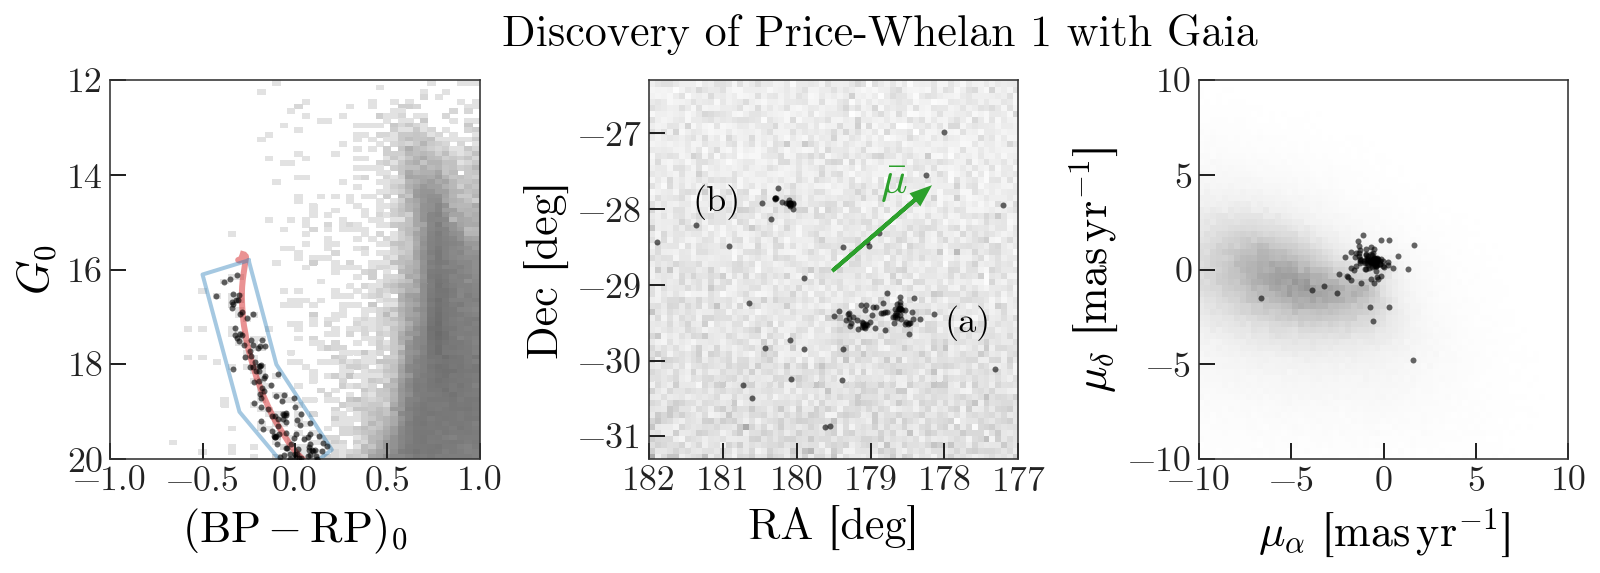

In [42]:
nodes = np.array([[-0.25, 15.8],
                  [-0.1, 18.],
                  [0.2, 19.8],
                  [0.0, 20.4],
                  [-0.3, 19.],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
polygon = mpl.path.Path(nodes)
mask = polygon.contains_points(np.vstack((g.BP0-g.RP0, g.G0)).T)

fig, axes = plt.subplots(1, 3, figsize=(11, 3.9), 
                         constrained_layout=True)

make_panel(axes[0],
           col=g.BP0-g.RP0,
           mag=g.G0,
           col_lim=(-1, 1),
           mag_lim=(12, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$',
           poly_mask=mask)

axes[0].plot(nodes[:, 0], nodes[:, 1], 
             marker='', color='tab:blue', lw=2, alpha=0.4)
axes[0].set_ylim(20, 12)

style = dict(marker='', linewidth=3, ls='-',
             alpha=0.5, color='tab:red', zorder=-100)

for iso, feh, ls in zip(mist_isos, fehs, lses):
    axes[0].plot(iso['G_BP'] - iso['G_RP'], 
                 iso['G'] + coord.Distance(29*u.kpc).distmod.value, 
                 label=r'MIST $[{\rm Fe}/{\rm H}] =' + ' {:.1f}$'.format(feh),
                 **style)

# ------
# Sky plot

ax = axes[1]

ax.set_xlim(cluster_c.ra.degree + 2.5,
            cluster_c.ra.degree - 2.5)
ax.set_ylim(cluster_c.dec.degree - 2.5,
            cluster_c.dec.degree + 2.5)

H, xe, ye = np.histogram2d(all_g.ra, all_g.dec, 
                           bins=(np.linspace(*ax.get_xlim()[::-1], num=64),
                                 np.linspace(*ax.get_ylim(), num=64)))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmax=2 * H.max())
ax.plot(g.ra[mask], 
        g.dec[mask], 
        **dark_ptstyle)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

dx, dy = cluster_pm * 2
ax.arrow(cluster_c.ra.degree,
         cluster_c.dec.degree,
         dx.value, dy.value, 
         head_width=0.15, head_length=0.2,
         linewidth=2, color='tab:green', zorder=1000)

ax.text(180.76, -27.9, '(b)', 
        fontsize=18, va='center', ha='right')
ax.text(178., -29.5, '(a)', 
        fontsize=18, va='center', ha='left')
ax.text(178.5, -27.8, r'$\bar{\mu}$', ha='right',
        fontsize=22, color='tab:green')

# ------
# PM plot

ax = axes[2]

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

H, xe, ye = np.histogram2d(all_g.pmra, all_g.pmdec, 
                           bins=(np.linspace(*ax.get_xlim(), num=64),
                                 np.linspace(*ax.get_ylim(), num=64)))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmax=2 * H.max())
ax.plot(g.pmra[mask], 
        g.pmdec[mask], 
        **dark_ptstyle)

ax.set_xlabel(r'$\mu_\alpha$ [{:latex_inline}]'.format(u.mas/u.yr))    
ax.set_ylabel(r'$\mu_\delta$ [{:latex_inline}]'.format(u.mas/u.yr))

axes[0].xaxis.set_ticks(np.arange(-1, 1+1e-3, 0.5))
axes[1].xaxis.set_ticks(np.arange(177, 182+1e-3, 1))
axes[2].xaxis.set_ticks(np.arange(-10, 10+1e-3, 5))

fig.suptitle('Discovery of Price-Whelan 1 with Gaia', x=0.55, fontsize=22)

fig.savefig(fig_path / 'gaia-cmd-pm.pdf', dpi=250)

In [29]:
g[mask].data.write('../data/gaia-cmd-polygon.fits')

ERROR: OSError: File exists: ../data/gaia-cmd-polygon.fits [astropy.io.fits.connect]


OSError: File exists: ../data/gaia-cmd-polygon.fits

---

Evolved members?

In [36]:
feh = -1.1
fn = '/Users/adrian/data/Isochrones/MIST/FeH_{:.1f}_iso.fits'.format(feh)
all_iso = Table.read(fn)
iso = all_iso[np.isclose(all_iso['log10_isochrone_age_yr'], 8.)]
# iso = iso[np.isin(iso['phase'], [0])]

In [64]:
cluster_mask = all_g.get_skycoord(distance=False).separation(cluster_c) < 2*u.deg
pm_shit_mask = np.sqrt((all_g.pmra.value - -0.56)**2 + (all_g.pmdec.value - 0.47)**2) < 1
# pm_shit_mask = np.sqrt((all_g.pmra.value - -0.56)**2 + (all_g.pmdec.value - 0.47)**2) > 1.5
high_prob = all_g[cluster_mask & pm_shit_mask]
more_mask = (high_prob.parallax_over_error < 8) | ((high_prob.parallax_over_error > 8) & (high_prob.parallax < 0.25*u.mas))
high_prob = high_prob[more_mask]

_bprp = high_prob.BP0 - high_prob.RP0
evolved_mask = (_bprp > 1.) & (_bprp < 1.2) & (high_prob.G0 > 13)  & (high_prob.G0 < 14.5)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


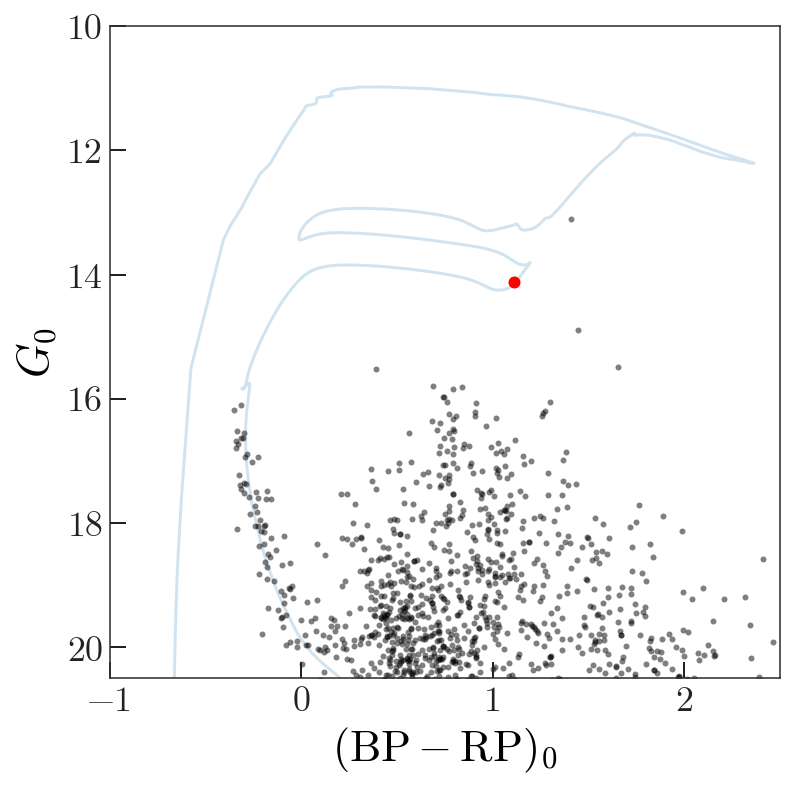

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

make_panel(ax,
           col=high_prob.BP0-high_prob.RP0,
           mag=high_prob.G0,
           col_lim=(-1, 2.5),
           mag_lim=(10, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$')

ax.scatter((high_prob.BP0-high_prob.RP0)[evolved_mask],
           high_prob.G0[evolved_mask], color='r')

ax.plot(iso['G_BP'] - iso['G_RP'], 
        iso['G'] + coord.Distance(29*u.kpc).distmod.value, 
        label=r'MIST $[{\rm Fe}/{\rm H}] =' + ' {:.1f}$'.format(feh),
        marker='', zorder=-100, alpha=0.2)

In [70]:
dude = high_prob[evolved_mask].data
dude['ra', 'dec']

ra,dec
float64,float64
181.215096814,-28.8517678283


---

# OLD

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


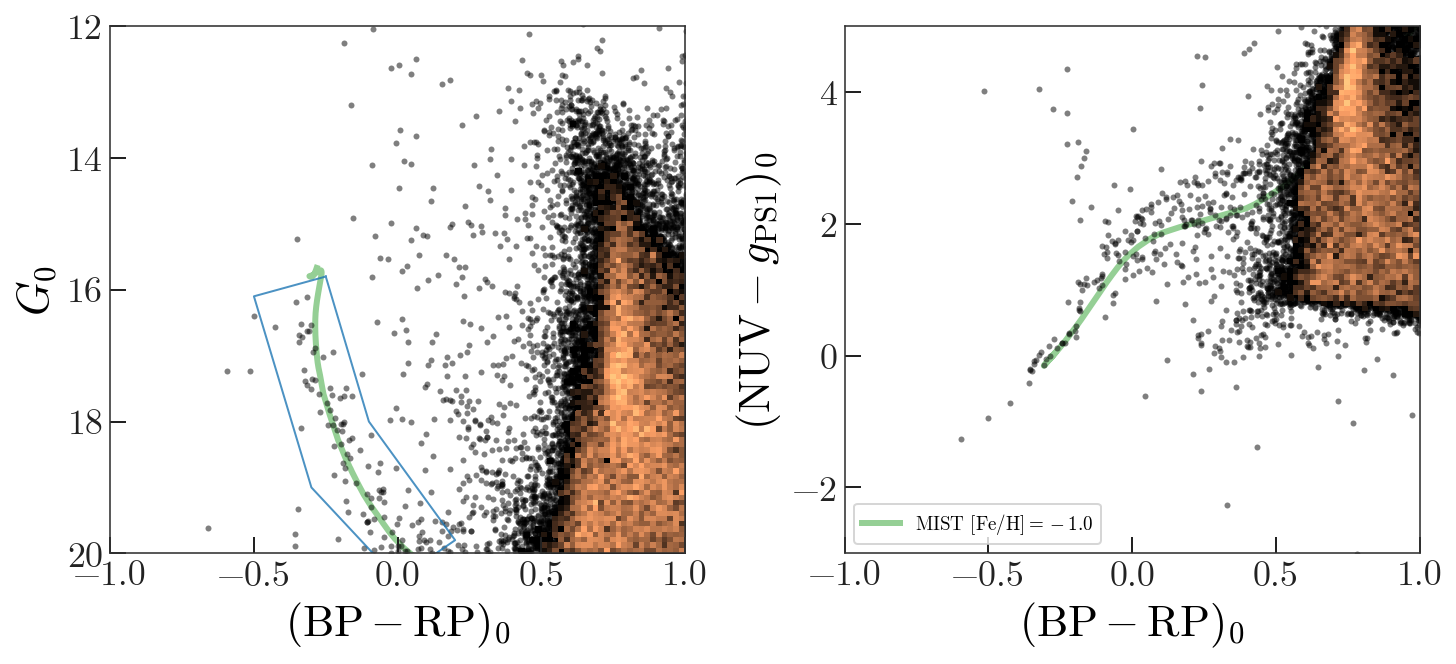

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), 
                         constrained_layout=True)

make_panel(axes[0],
           col=g.BP0-g.RP0,
           mag=g.G0,
           col_lim=(-1, 1),
           mag_lim=(12, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$')

NUV = g.NUV0.copy()
NUV[g.galex_NUV == 20.565] = np.nan
make_panel(axes[1],
           col=g.BP0-g.RP0,
           mag=NUV-g.g0,
           col_lim=(-1, 1),
           mag_lim=(-3, 5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$({\rm NUV}-g_{\rm PS1})_0$',
           flipy=False)

nodes = np.array([[-0.25, 15.8],
                  [-0.1, 18.],
                  [0.2, 19.8],
                  [0.0, 20.4],
                  [-0.3, 19.],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
axes[0].plot(nodes[:, 0], nodes[:, 1], 
             marker='', color='tab:blue', lw=1, alpha=0.8)
axes[0].set_ylim(20, 12)

polygon = mpl.path.Path(nodes)
# polygon.contains_points()

style = dict(marker='', linewidth=3, ls=ls,
             alpha=0.5, color='tab:green', zorder=-100)

for iso, feh, ls in zip(mist_isos, fehs, lses):
    axes[0].plot(iso['G_BP'] - iso['G_RP'], 
                 iso['G'] + coord.Distance(29*u.kpc).distmod.value, 
                 **style)
    
    axes[1].plot(iso['G_BP'] - iso['G_RP'], 
                 iso['NUV'] - iso['ps1_g'], 
                 label=r'MIST $[{\rm Fe}/{\rm H}] =' + ' {:.1f}$'.format(feh),
                 **style)
    
axes[1].legend(loc='lower left', fontsize=9.5, ncol=2)


# fig.savefig(fig_path / 'gaia-galex-cmd.pdf', dpi=250)